In [1]:
import os, time, sys
import numpy as np
# np.random.bit_generator = np.random._bit_generator
import torch
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
# import imgaug
# from AdaBound import adabound
device = "cuda"

# Se_Net3

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Sq_Ex_Block(nn.Module):
    def __init__(self, in_ch, r=16):
        super(Sq_Ex_Block, self).__init__()
        self.se = nn.Sequential(
            GlobalAvgPool(),
            nn.Linear(in_ch, in_ch//r),
            nn.ReLU(inplace=True),
            nn.Linear(in_ch//r, in_ch),
            nn.Sigmoid()
        )

    def forward(self, x):
        se_weight = self.se(x).unsqueeze(-1).unsqueeze(-1)
#         print(f'x:{x.sum()}, x_se:{x.mul(se_weight).sum()}')
        return x.mul(se_weight)

class GlobalAvgPool(nn.Module):
    def __init__(self):
        super(GlobalAvgPool, self).__init__()
    def forward(self, x):
        return x.view(*(x.shape[:-2]),-1).mean(-1)

class SE_Net3(nn.Module):
    def __init__(self,in_channels):
        super(SE_Net3,self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #                dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64,eps=1e-3,momentum=0.01)
        self.c2 = nn.Conv2d(64,64,3,1,0)
        self.bn2 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c3 = nn.Conv2d(64,64,3,1,1)
        self.bn3 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c4 = nn.Conv2d(64,64,5,1,2)
        self.bn4 = nn.BatchNorm2d(64,1e-3,0.01)        
        
        self.m1 = nn.MaxPool2d((3,3))
        self.d1 = nn.Dropout(0.5)
        
        self.c5 = nn.Conv2d(64,128,3,1,0)
        self.bn5 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c6 = nn.Conv2d(128,128,3,1,0)
        self.bn6 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c7 = nn.Conv2d(128,128,3,1,1)
        self.bn7 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c8 = nn.Conv2d(128,128,5,1,2)
        self.bn8 = nn.BatchNorm2d(128,1e-3,0.01)
        
        self.m2 = nn.MaxPool2d((2,3))
        self.d2 = nn.Dropout(0.5)
        
        self.c9 = nn.Conv2d(128,256,3,1,0)
        self.bn9 = nn.BatchNorm2d(256,1e-3,0.01)
        self.c10 = nn.Conv2d(256,256,3,1,1)
        self.bn10 = nn.BatchNorm2d(256,1e-3,0.01)
        
        self.se1 = Sq_Ex_Block(in_ch=256,r=16)
        self.m3 = nn.MaxPool2d((2,2))
        self.d3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256*3*5,256)
        self.bn11 = nn.BatchNorm1d(256,1e-3,0.01)
        self.out_root = nn.Linear(256,168)
        self.out_vowel = nn.Linear(256,11)
        self.out_constant = nn.Linear(256,7)
        
#         self.init_linear_weights()
        
    def forward(self,x):
        x = self.bn1(F.leaky_relu(self.c1(x),0.05))
        x = self.bn2(F.leaky_relu(self.c2(x),0.05))
        x = self.bn3(F.leaky_relu(self.c3(x),0.05))
        x = self.bn4(F.leaky_relu(self.c4(x),0.05))
        x = self.d1(self.m1(x))
        
        x = self.bn5(F.leaky_relu(self.c5(x),0.05))
        x = self.bn6(F.leaky_relu(self.c6(x),0.05))
        x = self.bn7(F.leaky_relu(self.c7(x),0.05))
        x = self.bn8(F.leaky_relu(self.c8(x),0.05))
        x = self.d2(self.m2(x))
        
        x = self.bn9(F.leaky_relu(self.c9(x),0.05))
        x = self.bn10(F.leaky_relu(self.c10(x),0.05))
        x = self.se1(x)
        x = self.d3(self.m3(x))
        
#         print(x.size())   #Determine fc1 input size
        
        x = x.view(-1, 256*3*5) #reshape
        x = self.bn11(F.leaky_relu(self.fc1(x),0.05))
        
        
        return self.out_root(x),self.out_vowel(x),self.out_constant(x)
    
#     def init_linear_weights(self):
#         nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')  #default mode: fan_in
#         nn.init.kaiming_normal_(self.out_root.weight, mode='fan_in')
#         nn.init.kaiming_normal_(self.out_vowel.weight, mode='fan_in')
#         nn.init.kaiming_normal_(self.out_constant.weight, mode='fan_in')


# Efficient net

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b3')

out_channels = 1280  #eff-b0
# out_channels = 1536  #eff-b3


class EffNet(nn.Module):
    def __init__(self,in_channels=3):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0',in_channels=in_channels)
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(0.2)
        self._fc_root = nn.Linear(out_channels, 168)
        self._fc_vowel = nn.Linear(out_channels, 11)
        self._fc_constant = nn.Linear(out_channels, 7)
        
    def forward(self, inputs):
        bs = inputs.size(0)
        # Convolution layers
        x = self.backbone.extract_features(inputs)
#         print("feature size:", x.size())
        
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)

        out_root = self._fc_root(x)
        out_vowel = self._fc_vowel(x)
        out_constant = self._fc_constant(x)
        
        return out_root, out_vowel, out_constant
        
        

# SE_Res_NET

In [4]:
from se_resnet import *
from collections import OrderedDict

def get_resnext_model(model_type="101", pretrained=True):
    if model_type == "101":
        model = se_resnext101_32x4d(num_classes=1000, pretrained=pretrained)
    elif model_type== "50":
        model = se_resnext50_32x4d(num_classes=1000, pretrained=pretrained)
    else:
        print("!!!Wrong se_res model structure!!!")
        return
    inplanes = 64  ###inplanes above!!!
    input_channels = 1
    layer0_modules = [
        ('conv1', nn.Conv2d(input_channels, inplanes, kernel_size=7, stride=2,    
                            padding=3, bias=False)),
        ('bn1', nn.BatchNorm2d(inplanes)),
        ('relu1', nn.ReLU(inplace=True)),
    ]        
    layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,ceil_mode=True)))
    model.layer0 = nn.Sequential(OrderedDict(layer0_modules))
    model.classifier_root = nn.Linear(model.feature_dim, 168)
    model.classifier_vowel = nn.Linear(model.feature_dim, 11)
    model.classifier_constant = nn.Linear(model.feature_dim, 7)
    return model
    

# Test model output

In [5]:
# # model = SE_Net3(in_channels=1)
# # model = EffNet(in_channels=1)
# # model = se_resnext()
# # model = se_resnext101_32x4d(num_classes=1000, pretrained=True)
# model = get_resnext_model(model_type="50")
# model.cuda()

# # # summary(model, input_size=(3, 28, 28))
# tensor_in = torch.zeros(size=(2,1,224,224),dtype=torch.float32).to("cuda")
# # output = model(tensor_in)
# pred_r, pred_v, pred_c = model.new_forward(tensor_in)
# print(pred_r.size(),pred_v.size(),pred_c.size())
# print("done")

# Data preprocessing

In [6]:
debug = False
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet('{}/{}_image_data_{}.parquet'.format(datadir,data_type,i)) for i in indices]
    else:
        image_df_list = [pd.read_feather('{}/{}_image_data_{}.feather'.format(featherdir,data_type,i)) for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
#     images = np.ones_like(images*255).astype('uint8') - images
    
    del image_df_list
#     gc.collect()
    images = np.concatenate(images, axis=0)
    return images


train_pd = pd.read_csv('./dataset/train.csv')
###Compute raw data
# train_labels = train_pd[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# datadir = featherdir = "./dataset/"
# tmp_indices = [0] if debug else [0, 1, 2, 3]
# train_images = prepare_image(datadir, featherdir, data_type='train', submission=True, indices=tmp_indices)

###load from npy
# train_images = np.load("./train_images_shuffle_0202.npy")
train_images = np.load("./train_images_invert_0203.npy")
train_labels = np.load("./train_labels_shuffle_0202.npy")

In [7]:
# tmp_images = np.uint8(np.ones_like(train_images).astype('uint8')*255)
# tmp_images = tmp_images - train_images
# np.save("./train_images_invert_0203.npy", tmp_images)

In [8]:
# print("Shuffle...")
# data_num = np.shape(train_labels)[0]
# tmp_images = np.uint8(train_images).reshape(data_num,-1)
# tmp_labels = np.uint8(train_labels).reshape(data_num,-1)
# print(np.shape(tmp_images))
# print(np.shape(tmp_labels))
# tmp_file = np.concatenate((tmp_labels,tmp_images),axis=1)

# np.random.shuffle(tmp_file)
# print("tmp_file shape:",np.shape(tmp_file))
# print("Done")

# tmp_images = tmp_file[:,3:].reshape(-1,137,236)
# tmp_labels = tmp_file[:,:3]

# np.save("./train_images_shuffle_0202.npy", tmp_images)
# np.save("./train_labels_shuffle_0202.npy", tmp_labels)

# ###load from npy
# train_images = np.load("./train_images_shuffle_0202.npy")
# train_labels = np.load("./train_labels_shuffle_0202.npy")

In [9]:
# from imgaug import augmenters as iaa
# # from imgaug.augmentables.segmaps import SegmentationMapOnImage
# class ImgAugTransform:
#     def __init__(self):
#         self.aug = iaa.Sequential([
# #         iaa.Scale((75, 128)),
# #         iaa.Fliplr(0.5),
# #         iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.6))),
# #         iaa.Sometimes(0.1, iaa.AverageBlur(1.2)),
# #         iaa.Sometimes(1, iaa.Affine(rotate=(-20, 20),order=[0, 1],translate_px={"x":(-2, 2),"y":(-2,2)},mode='symmetric')),
# #         iaa.Sometimes(0.2,iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.25))),
# #         iaa.Sometimes(0.1, iaa.SaltAndPepper(0.05,False)),
#         iaa.Invert(1),
# #         iaa.Add((-5, 5)), # change brightness of images (by -10 to 10 of original value)
# #         iaa.AdditiveGaussianNoise(-1,1)
# #         iaa.Sometimes(0.2,iaa.GammaContrast(2))
            
# #         iaa.AddToHueAndSaturation(from_colorspace="GRAY",value=(-20, 20))  #Hue-> color, saturation -> saido
#     ])
#     def __call__(self, img, mask=None):
#         img = np.array(img)        
#         return self.aug.augment_image(image=img)
# #         return self.aug(image=img, segmentation_maps=label)

# CutMix augmentation

In [10]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = \
    targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    
#     print("here", preds1.size(), np.shape(targets1))
    return lam * criterion(preds1, targets1) + (1 - lam) * \
           criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * \
           criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)


def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

# Trans and Dataset definition

In [11]:
trans = transforms.Compose([
    
#         transforms.RandomResizedCrop(224),
        transforms.Resize((128,128)), #For resnet
#         transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4, 0.4, 0.4),
#         transforms.Resize((224,224)), #For resnet
#         transforms.ColorJitter(0.2,0.2,0.2,0.5),
#         transforms.RandomAffine(degrees=20,translate=(0.25,0.25),scale=[0.65,1.1],shear=15), #after 60k
#         ImgAugTransform(),
#         lambda x: Image.fromarray(x),
        transforms.RandomAffine(degrees=10,translate=(0.15,0.15),scale=[0.8,1.2]), #Bengarli baseline
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1  
#         transforms.Normalize(mean=[0.05302372],std=[0.15948994]) #train_images distribution

    ])

trans_none = transforms.Compose([
        transforms.Resize((128,128)), #For resnet
        transforms.ToTensor(),
])


trans_val = transforms.Compose([
        transforms.Resize((128,128)), #For resnet
#         ImgAugTransform(),
#         lambda x: Image.fromarray(x),
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1  
#         transforms.Normalize(mean=[0.05302372],std=[0.15948994]) #train_images distribution
    ])

# print(train_images.shape) #(200840, 137, 236), [0,255]
# print(train_labels.shape) #(200840, 3)
# print(np.max(train_labels[0])) #0~15
# print(np.max(train_labels[1])) #0~159
# print(np.max(train_labels[2])) #0~22

class BengaliDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None,indices=None):
        self.is_validate = is_validate
        self.data = train_images
        self.label = train_labels
        if data_len == None:
            data_len = len(self.data)
        
        self.indices = indices
        if self.is_validate:
            self.len = int(data_len*validate_rate)
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_val
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            self.transform = trans
            
        self.trans_none = trans_none
        
    def __getitem__(self, idx):
        idx += self.offset
        idx = self.indices[idx]
        
        img = np.uint8(self.data[idx]) #(137,236), value: 0~255
        labels = self.label[idx] #(num,3) grapheme_root, vowel_diacritic, constant_diacritic
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,137,236)
            
        ###For input channels = 3 (in order to load pretrained weight)
#         img = np.tile(img, (3,1,1))
        
        label = torch.as_tensor(labels, dtype=torch.uint8)    #value: 0~9, shape(3)
#         print("here",np.shape(labels))

#         return img, labels
        return img, labels

    def __len__(self):
        return self.len

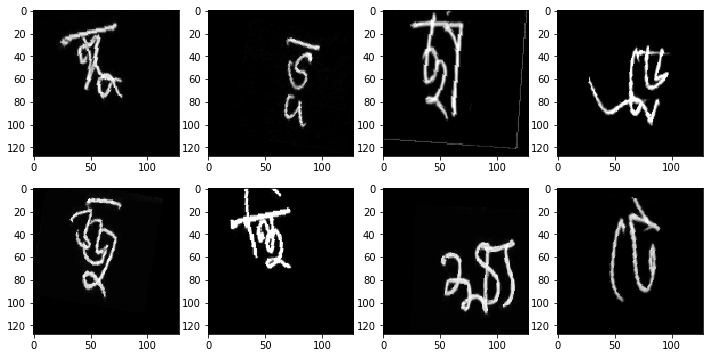

In [28]:
# Show augmented result
indices_len = len(train_images)
ind = np.arange(indices_len)
tmp = BengaliDataset(data_len=None,is_validate=False, validate_rate=0.9,indices=ind)
tmp_loader = DataLoader(tmp, batch_size=1, shuffle=True, num_workers=1)
fig, axes = plt.subplots(2,4,figsize=(12,6))
axes = axes.flatten()

for i,data in enumerate(tmp_loader):
    if i==8:
        break
    img, labels = data
    img, labels = img.to(device), labels.to(device).long()
    
#     print(img.size())
#     print(labels.size(),labels.type())
#     print(np.shape(img[:,None,:,:]))
    
    ###Cutmix test
#     if np.random.random()<0.5:
#         aug_img, targets = cutmix(img, labels[:,0],labels[:,1],labels[:,2],alpha=1)
#         pred_root, pred_vowel, pred_constant = model(aug_img)
#         loss = cutmix_criterion(pred_root,pred_vowel,pred_constant,targets)
#         print(loss.item())
        
#     print(aug_img.size(),aug_img.type())
#     print(len(targets),targets[0].size(),targets[0].type())
    
#     img = torch.as_tensor(img, dtype=torch.uint8)
#     labels = torch.as_tensor(labels, dtype=torch.uint8)
#     print(type(img))
#     print(type(labels))
    axes[i].imshow(img[0][0].cpu().numpy(),cmap='gray')
#     plt.pause(.1)
#     print(label)

# Get kfold dataset loader

In [13]:
def get_kfold_dataset_loader(k=5,val_rate=0.1,indices_len=None, batch_size=None,num_workers=None):
    ###Return [list of train dataset_loader, list of val dataset_loader]
    train_loader_list = []
    val_loader_list = []
    indices = np.arange(indices_len)
    val_len = indices_len//k
    idx = 0
    
    for i in range(k):
#         np.random.shuffle(indices)  #Random cross validation
        ind = np.concatenate([indices[:idx],indices[idx+val_len:],indices[idx:idx+val_len]])
        idx += val_len
        
        train_dataset = BengaliDataset(data_len=None,is_validate=False, validate_rate=val_rate,indices=ind)
        val_dataset = BengaliDataset(data_len=None,is_validate=True, validate_rate=val_rate, indices=ind)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        train_loader_list.append(train_loader)
        val_loader_list.append(val_loader)
        
    return train_loader_list, val_loader_list


# Get models

In [14]:
def get_model():
#     model = SE_Net3(in_channels=1)
#     model = EffNet(in_channels=1)
    model = get_resnext_model(model_type="50", pretrained="False")
    if device == "cuda":
        model.cuda()
    return model


# Get dataset distribution

In [15]:
# train distribution: mean=[0.08229437],std=[0.23876116]
# dig augmented distribution: mean=[0.09549136],std=[0.24336776]
# train large distribution: mean=[0.08889286],std=[0.24106438]

def get_dataset_mean_std(dataloader):
    print("Calculate distribution:")
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in dataloader:
        img = data[0].to(device)
        batch_samples = img.size(0)
        img = img.contiguous().view(batch_samples, img.size(1), -1)
        mean += img.mean(2).sum(0)
        std += img.std(2).sum(0)
        nb_samples += batch_samples
        if nb_samples%5120 == 0:
            print("Finished:", nb_samples)
            
    print("num of samples:",nb_samples)
    mean /= nb_samples
    std /= nb_samples
#     print("Average mean:",mean)
#     print("Average std:", std)
    return mean.cpu().numpy(), std.cpu().numpy()

# Get train and val loaders

In [16]:
batch_size = 32
num_workers = 12
k = 1
indices_len = 200840
vr = 0.01

# indices_len = 10240  ################Temp Revised Caution##############
# indices_len = 120000

###Single dataset
# indices = np.arange(indices_len)
# train_dataset = BengaliDataset(data_len=None,is_validate=False,validate_rate=vr,indices=indices)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# mean, std = get_dataset_mean_std(train_loader)
# print("train distribution: mean={},std={}".format(mean, std))

# indices = np.arange(10240)
# dig_val_dataset = DigValDataset(data_len=None,indices=indices)
# dig_val_loader = DataLoader(dig_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# mean, std = get_dataset_mean_std(dig_val_loader)
# print("validate distribution:",mean, std)

# test_dataset = TestDataset(data_len=None)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# mean, std = get_dataset_mean_std(test_loader)
# print("test distribution:",mean, std)

###K-fold dataset
# vr = (indices_len//k)/indices_len
print("validation rate:",vr)
train_loaders, val_loaders = get_kfold_dataset_loader(k, vr, indices_len, batch_size, num_workers)

validation rate: 0.01


# Train digit classifier

In [ ]:
if __name__ == "__main__":
    epochs = 300
    ensemble_models = []
    lr = 1e-3
    val_period = 1000
    train_period = 100
    criterion = torch.nn.CrossEntropyLoss()
    cutmix_tag = False
#     criterion_b = torch.nn.BCEWithLogitsLoss()
    while True:
        print("Fold:",len(train_loaders))

        for fold in range(0,len(train_loaders)):
            train_loader = train_loaders[fold]
            val_loader = val_loaders[fold]
            model = get_model()
            max_acc = 0
            min_loss = 10000
            best_model_dict = None
            data_num = 0
            loss_avg = 0
            loss_root_avg = 0
            loss_vowel_avg = 0
            loss_constant_avg = 0

#             optimizer = torch.optim.Adamax(model.parameters(),lr=0.002,weight_decay=0)
    #         optimizer = torch.optim.SGD(model.parameters(),lr=lr)
#             optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)
            optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9,0.99))
    #         optimizer = torch.optim.Adagrad(model.parameters(),lr=lr)
    #         optimizer = adabound.AdaBound(model.parameters(), lr=lr, final_lr=0.01,amsbound=True)
    #         optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4, nesterov=True)
    #         lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=period,T_mult=1,eta_min=1e-5) #original 
            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=30,factor=0.1)

            for ep in range(0,epochs+1):
                model.train()
                for idx, data in enumerate(train_loader):
#                     if idx%10 == 0:
#                         print(idx)
                    img, target = data
                    img, target = img.to(device), target.to(device,dtype=torch.long)
            
                    cutmix_tag = True if np.random.random()<0.5 else False
                
                    if cutmix_tag == True:
                        img, targets = cutmix(img, target[:,0],target[:,1],target[:,2],alpha=np.random.uniform(0.8,1))
            
                    pred_root, pred_vowel, pred_constant = model.new_forward(img)
#                     print(np.shape(img),np.shape(target)) #Tensor(batch,1,75,128)
#                     print(np.max(img.cpu().numpy()),np.min(img.cpu().numpy())) #1.0 0.0
                    
#                     print(pred_root.size())   #(batch,168)
#                     print(pred_vowel.size())   #(batch,11)
#                     print(pred_constant.size())   #(batch,7)
#                     print(target.size()) #(batch,3)
                    
                    ##Cutmix test
                    if cutmix_tag == True:
                        loss = cutmix_criterion(pred_root,pred_vowel,pred_constant,targets)
#                         print(loss.item())                        
                    else:
                        ###Input shape: input:(batch_num,1), target:(batch_num,a int 0 or 1) for CSE LOSS, target:(batch_num,1) for BCE loss
        #                 loss_b = criterion_b(pred_b,target_b) 
                        ###Input shape: input:(batch_num,10), target:(batch_num,a int between 0~10)
    #                     print(target[:,0].shape)
                        loss_root = criterion(pred_root,target[:,0])
                        loss_vowel = criterion(pred_vowel,target[:,1])
                        loss_constant = criterion(pred_constant,target[:,2])
                        loss = loss_root + loss_vowel + loss_constant
                        loss_root_avg += loss_root.item()
                        loss_vowel_avg += loss_vowel.item()
                        loss_constant_avg += loss_constant.item()
                        loss_avg += loss.item()

                    data_num += img.size(0)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    ###Evaluate Train Loss 
#                     if idx%train_period == 0:
#                         loss_avg /= data_num
#                         loss_root_avg /= data_num
#                         loss_vowel_avg /= data_num
#                         loss_constant_avg /= data_num
#                         print("Train Ep:{},loss:{:.3f},rl:{:.3f},vl{:.3f},cl{:.3f},lr:{}".
#                               format(ep, loss_avg,loss_root_avg,loss_vowel_avg,loss_constant_avg,optimizer.param_groups[0]['lr']))
#                         loss_avg = loss_root_avg = loss_vowel_avg = loss_constant_avg = 0
#                         data_num = 0

                    ###Cosine annealing
        #             lr_scheduler.step()                    

                    ###Validation
                    if idx!=0 and idx%val_period == 0:
                        model.eval()
                        acc_root = 0
                        acc_vowel = 0
                        acc_constant = 0
                        acc = 0
                        val_loss_root = 0
                        val_loss_vowel = 0
                        val_loss_constant = 0
                        val_loss = 0
                        data_num  = 0
                        with torch.no_grad():
                            for idx, data in enumerate(val_loader):
                                img, target = data
                                img, target = img.to(device), target.to(device,dtype=torch.long)
                                tmp = model(img)
                                pred_root, pred_vowel, pred_constant = model.new_forward(img)
                                
                                val_loss_root += criterion(pred_root, target[:,0]).item()
                                val_loss_vowel += criterion(pred_vowel, target[:,1]).item()
                                val_loss_constant += criterion(pred_constant, target[:,2]).item()

                                # print(pred) 
                                _,pred_class_root = torch.max(pred_root.data, 1)
                                _,pred_class_vowel = torch.max(pred_vowel.data, 1)
                                _,pred_class_constant = torch.max(pred_constant.data, 1)

            #                   print(pred_class)
                                acc_root += (pred_class_root == target[:,0]).sum().item()
                                acc_vowel += (pred_class_vowel == target[:,1]).sum().item()
                                acc_constant += (pred_class_constant == target[:,2]).sum().item()

                                data_num += img.size(0)

                        acc_root /= data_num
                        acc_vowel /= data_num
                        acc_constant /= data_num
                        val_loss_root /= data_num
                        val_loss_vowel /= data_num
                        val_loss_constant /= data_num

                        acc = (2*acc_root + acc_vowel + acc_constant)/4
                        val_loss = (2*val_loss_root + val_loss_vowel + val_loss_constant)/4

                        ###Plateau
#                         lr_scheduler.step(val_loss)               
                        lr_scheduler.step(-1*acc)                  

                        if acc >= max_acc:
                            max_acc = acc
                            min_loss = val_loss
                            best_model_dict = model.state_dict()                    

                            if max_acc>0.97:
                                torch.save(best_model_dict, "./Bengali_saved_model/adam_eff_Fold{}_acc{:.4f}".format(fold,max_acc*1e2))
                        
                        torch.save(best_model_dict, "./Bengali_saved_model/adam_eff_Fold{}_current".format(fold))
                        
        #                 if val_loss <= min_loss:
        #                     max_acc = acc
        #                     min_loss = val_loss
        #                     best_model_dict = model.state_dict()

                        print("Val Ep{},Loss:{:.6f},rl{:.4f},vl{:.4f},cl{:.4f},Acc:{:.4f}%,ra:{:.4f}%,va:{:.4f}%,ca:{:.4f}%,lr:{}"
                              .format(ep,val_loss,val_loss_root,val_loss_vowel,val_loss_constant,acc*100,acc_root*100,acc_vowel*100,acc_constant*100,optimizer.param_groups[0]['lr']))

                if optimizer.param_groups[0]['lr'] < 1e-5:
                    break         
                    
            ###K-Fold ensemble: Saved k best model for k dataloader
            print("===================Best Fold:{} Saved Loss:{} Acc:{}==================".format(fold,min_loss,max_acc))
            torch.save(best_model_dict, "./Bengali_saved_model/adam_eff_Fold{}_loss{:.4f}_acc{:.3f}".format(fold,min_loss*1e3,max_acc*1e2))
            print("======================================================")

            del model
            torch.cuda.empty_cache()


In [ ]:
print(max_acc)
torch.save(best_model_dict, "./Bengali_saved_model/Fold{}_acc{}".format(fold,max_acc))

# Native classifier Emsemble inference

In [ ]:
# transforms.Normalize(mean=[0.08229437],std=[0.23876116]) #train dataset dist
# transforms.Normalize(mean=[0.09549136],std=[0.24336776]) #dig_augmented distribution        
# transforms.Normalize(mean=[0.08889289],std=[0.24106446])  #train_large dataset distribution


ensemble_root = "./Kmnist_saved_model/senet2_5x2fold_65k"   #model-> 1 fc(512) + dropout(0.1)
ensemble_models = []

ensemble_root_dig = "./Kmnist_saved_model/ensemble_dig/baseline_cnn_60k_3fold"    #model-> 1 fc(256) + dropout(0.2)
ensemble_models_dig = []

data_num = 0
acc = 0

# mean,std = 0.08229437, 0.23876116
# mean_dig,std_dig = 0.09549136, 0.24336776
# mean_large,std_large = 0.08889289, 0.24106446

vr = 1
# indices = np.arange(60000)
# test_dataset = KMnistDataset(data_len=None,is_validate=True, validate_rate=vr,indices=indices)
indices = np.arange(120000)
test_dataset = KMnistDataset_binary_aid(data_len=None,is_validate=True, validate_rate=vr,indices=indices)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

native_model = convNet_native(in_channels=1)
native_model.cuda()
native_model.load_state_dict(torch.load("./Kmnist_saved_model/native_classifier/old/Fold0_loss0.0242_acc_b99.704_without_aug"))
native_model.eval()   

for file_name in os.listdir(ensemble_root):
    if file_name.find("Fold") == -1:
        continue
    model = SE_Net2(in_channels=1)
    model.cuda()
    model.load_state_dict(torch.load("{}/{}".format(ensemble_root,file_name)))
    model.eval()
    ensemble_models.append(model)

for file_name in os.listdir(ensemble_root_dig):
    if file_name.find("Fold") == -1:
        continue
    model = convNet(in_channels=1)
    model.cuda()
    model.load_state_dict(torch.load("{}/{}".format(ensemble_root_dig,file_name)))
    model.eval()
    ensemble_models_dig.append(model)
    
### Test Native Classifier
with torch.no_grad():
    for idx,data in enumerate(test_loader):
        ###Classify native or not
        img, target_b, target = data
        img, target = img.to(device), target.to(device,dtype=torch.long)
        _,pred_native = torch.max(native_model(img),dim=1)  #(batch_num,)
        
        ###Classify by normal model, Average Ensemble
        pred_list = torch.Tensor([]).to(device)
        model_num = len(ensemble_models)
        for i in range(model_num):
            pred = ensemble_models[i](img) #(batch_num,10)
            pred_list = torch.cat((pred_list,pred.unsqueeze(2)),dim=2) #pred_list: (batch_num,10,model_num)
        pred = torch.mean(pred_list,dim=2)   #(batch,10)
        _,pred_class = torch.max(pred.data, 1)   #(batch_num,)
        
        
        ###Classify by dig_aug_model, Average Ensemble
        pred_list = torch.Tensor([]).to(device)
        model_num = len(ensemble_models_dig)
        for i in range(model_num):
            pred = ensemble_models_dig[i](img) #(batch_num,10)
            pred_list = torch.cat((pred_list,pred.unsqueeze(2)),dim=2) #pred_list: (batch_num,10,model_num)
        pred = torch.mean(pred_list,dim=2)   #(batch,10)
        _,pred_class_dig = torch.max(pred.data, 1)   #(batch_num,)
        
        ###Make final result tensor
        native_mask = pred_native    #(batch_num,)  ex: ([1,0,0,1,0])
        nonnative_mask = torch.ones([img.size(0),], dtype=torch.long).to(device) - native_mask  #(batch_num,) ex:([0,1,1,0,1])
        
        r1 = (pred_class*native_mask)  #a*b = torch.mul(a,b)
        r2 = (pred_class_dig*nonnative_mask)
        pred_final = (r1+r2).to(torch.long)  #(batch_num,)

#         print("model1:",pred_class)
#         print("model2:",pred_class_dig)
#         print("mask:",native_mask)
#         print("non_mask:",nonnative_mask)
#         print("r1:",r1)
#         print("r2:",r2)
#         print("result:",result)
#         print("target:",target)
#         stop
    
#         acc += (pred_native).sum().item()
        acc += (pred_final == target).sum().item()
        data_num += img.size(0)

#     val_loss /= data_num
    acc /= data_num
    print("Acc:{:.4f}%".format(acc*100))


# Ensemble critical digits inference

In [ ]:
ensemble_root = "./Kmnist_saved_model/senet2_5x2fold_65k"
ensemble_critical_root = "./Kmnist_saved_model/critical_classifier/01"
ensemble_models = []
ensemble_models_crit = []
epochs = 500
period = 100
model_num = epochs//period
model = 5
data_num = 0
acc = 0
acc_2step = 0

vr = 1
indices = np.arange(60000)
test_dataset = KMnistDataset(data_len=None,is_validate=True, validate_rate=vr,indices=indices)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

for file_name in os.listdir(ensemble_root):
    if file_name.find("Fold") == -1:
        continue
    model = SE_Net2(in_channels=1)
    model.cuda()
    model.load_state_dict(torch.load("{}/{}".format(ensemble_root,file_name)))
    model.eval()
    ensemble_models.append(model)
    
for file_name in os.listdir(ensemble_critical_root):
    if file_name.find("Fold") == -1:
        continue    
    model_crit = SE_Net2(in_channels=1)
    model_crit.out = nn.Linear(256,2)   #For critic cases classification
    model_crit.cuda()
    model_crit.load_state_dict(torch.load("{}/{}".format(ensemble_critical_root,file_name)))
    model_crit.eval()
    ensemble_models_crit.append(model_crit)

model_num = len(ensemble_models)
crit_model_num = len(ensemble_models_crit)
print("len of models:",len(ensemble_models))    
print("len of critical models:",len(ensemble_models_crit))    
result = np.array([])
result1 =np.array([])
label = np.array([])    
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        img, target = data
        img, target = img.to(device), target.to(device,dtype=torch.long)

        ###Average Ensemble
        pred_list = torch.Tensor([]).to(device)
        for i in range(model_num):
            pred = ensemble_models[i](img) #(batch_num,10)
            pred_list = torch.cat((pred_list,pred.unsqueeze(2)),dim=2) #pred_list: (batch_num,10,model_num)
        pred = torch.mean(pred_list,dim=2)   #(batch,10)
        _,pred_class = torch.max(pred.data, 1)   #(batch_num,)
        
        
        ###Advanced inference for critical classes:
        pred_list = torch.Tensor([]).to(device)
        for i in range(crit_model_num):
            pred = ensemble_models_crit[i](img) #(batch_num,10)
            pred_list = torch.cat((pred_list,pred.unsqueeze(2)),dim=2) #pred_list: (batch_num,10,model_num)
        pred = torch.mean(pred_list,dim=2)   #(batch,10)
        _,pred_class_crit = torch.max(pred.data, 1)   #(batch_num,)        
        
        ###Make final result tensor
        tensor1 = torch.tensor([1],dtype=torch.long).to(device)
        tensor0 = torch.tensor([0],dtype=torch.long).to(device)
        mask_1_0 = torch.where(pred_class==1,tensor1,tensor0) #(batch_num,)  ex: ([1,0,0,1,0])
        mask_others = torch.ones([img.size(0),], dtype=torch.long).to(device) - mask_1_0  #(batch_num,) ex:([0,1,1,0,1])
        
        r1 = (pred_class_crit*mask_1_0)  #a*b = torch.mul(a,b)
        r2 = (pred_class*mask_others)
        pred_final = (r1+r2).to(torch.long)  #(batch_num,)

#         print("pred_class:",pred_class)
#         print("pred_class_crit:",pred_class_crit)
#         print("mask_1_0:",mask_1_0)
#         print("mask_other:",mask_others)
#         print("r1:",r1)
#         print("r2:",r2)
#         print("pred:",pred_final)
        
        
        ###Voting Ensemble
#         pred_list = torch.LongTensor([]).to(device)
#         for i in range(model_num):
#             pred = ensemble_models[i](img) #(batch_num,10)
#             _,pred_class = torch.max(pred.data, 1)   #(batch_num,)
#             pred_list = torch.cat((pred_list,pred_class.unsqueeze(1)),dim=1)
            
#         pred_class_list = torch.LongTensor([]).to(device)
#         for i in range(img.size(0)):
#             pred_np = pred_list[i].cpu().numpy()
#             unique_class,count = np.unique(pred_np,return_counts=True)
#             unique_class = np.array(unique_class[np.argmax(count)]).reshape(-1)   #unique class shape(1,)
#             class_voted= torch.from_numpy(unique_class).to(device)    #(1,)
#             pred_class_list = torch.cat((pred_class_list,class_voted))    
    
#         acc += (pred_class == target).sum().item()
        acc += (pred_class == target).sum().item()
        acc_2step += (pred_final == target).sum().item()
        data_num += img.size(0)
        result = np.hstack([result,pred_class.cpu().numpy()])
        result1 = np.hstack([result1,pred_final.cpu().numpy()])
        label = np.hstack([label,target.cpu().numpy()])

#     val_loss /= data_num
    acc /= data_num
    acc_2step /= data_num
    print("Acc:{:.4f}%".format(acc*100))
    print("Acc 2step :{:.4f}%".format(acc_2step*100))


# Ensemble inference

In [ ]:
ensemble_root = "./Kmnist_saved_model/ensemble_tuned_cnn/senet2_5x2fold_65k_tmp"
ensemble_root2 = "./Kmnist_saved_model/ensemble_tuned_cnn/senet2_5fold_strong_aug_b768"
ensemble_models = []
ensemble_models2 = []

data_num = 0
acc = 0

vr = 1
indices = np.arange(60000)
test_dataset = KMnistDataset(data_len=None,is_validate=True, validate_rate=vr,indices=indices)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

for file_name in os.listdir(ensemble_root):
    if file_name.find("Fold") == -1:
        continue
    model = SE_Net2(in_channels=1)
    model.cuda()
    model.load_state_dict(torch.load("{}/{}".format(ensemble_root,file_name)))
    model.eval()
    ensemble_models.append(model)
    
for file_name in os.listdir(ensemble_root2):
    if file_name.find("Fold") == -1:
        continue    
    model2 = SE_Net2(in_channels=1)
    model2.cuda()
    model2.load_state_dict(torch.load("{}/{}".format(ensemble_root2,file_name)))
    model2.eval()
    ensemble_models2.append(model2)

model_num = len(ensemble_models)
model2_num = len(ensemble_models2)
print("len of models:",len(ensemble_models))    
print("len of models2:",len(ensemble_models2))    
result = np.array([])
result1 =np.array([])
label = np.array([])    
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        img, target = data
        img, target = img.to(device), target.to(device,dtype=torch.long)

        ###Average Ensemble
#         pred_list = torch.Tensor([]).to(device)
#         for i in range(model_num):
#             pred = ensemble_models[i](img) #(batch_num,10)
#             pred_list = torch.cat((pred_list,pred.unsqueeze(2)),dim=2) #pred_list: (batch_num,10,model_num)
#         ###inference for models2
#         for i in range(model2_num):
#             pred = ensemble_models2[i](img) #(batch_num,10)
#             pred_list = torch.cat((pred_list,pred.unsqueeze(2)),dim=2) #pred_list: (batch_num,10,model_num)
            
#         pred = torch.mean(pred_list,dim=2)   #(batch,10)
#         _,pred_class = torch.max(pred.data, 1)   #(batch_num,)        
        
        ###Voting Ensemble
        pred_list = torch.LongTensor([]).to(device)
        for i in range(model_num):
            pred = ensemble_models[i](img) #(batch_num,10)
            _,pred_class = torch.max(pred.data, 1)   #(batch_num,)
            pred_list = torch.cat((pred_list,pred_class.unsqueeze(1)),dim=1)
        for i in range(model2_num):
            pred = ensemble_models2[i](img) #(batch_num,10)
            _,pred_class = torch.max(pred.data, 1)   #(batch_num,)
            pred_list = torch.cat((pred_list,pred_class.unsqueeze(1)),dim=1)
            
        pred_class_list = torch.LongTensor([]).to(device)
        for i in range(img.size(0)):
            pred_np = pred_list[i].cpu().numpy()
            unique_class,count = np.unique(pred_np,return_counts=True)
            unique_class = np.array(unique_class[np.argmax(count)]).reshape(-1)   #unique class shape(1,)
            class_voted= torch.from_numpy(unique_class).to(device)    #(1,)
            pred_class_list = torch.cat((pred_class_list,class_voted))    
    
#         acc += (pred_class == target).sum().item()
        acc += (pred_class == target).sum().item()
        data_num += img.size(0)
        
#         result = np.hstack([result,pred_class.cpu().numpy()])
#         result1 = np.hstack([result1,pred_final.cpu().numpy()])
#         label = np.hstack([label,target.cpu().numpy()])

#     val_loss /= data_num
    acc /= data_num
    print("Acc:{:.4f}%".format(acc*100))


In [ ]:

print(np.where(label!=result)[0])
print(np.where(label!=result1)[0])

In [ ]:
self.data = global_dataimport torch
import numpy as np

t1 = torch.Tensor([[1,2,3,4],[4,3,2,1],[1,5,3,3]])  #(3,4)
t1 = t1.unsqueeze(2)

t_list = torch.Tensor([])

for i in range(3):
    t_list = torch.cat((t_list,t1),dim=2)

print(t_list.size())
print(t_list)
t_list = torch.mean(t_list,dim=2)
print(t_list.size())
print(t_list)


# n1 = t1.cpu().numpy()

# n1, count = np.unique(n1,return_counts=True,axis=0)
# print(count)
# n1 = np.argmax(count)

